In [ ]:
for i in [0, 2, 4, 8, 16, 20, 24, 28, 32, 40, 48, 56, 64, 80, 96, 112, 128]:
  print(i/256, end=", ")

0.0, 0.0078125, 0.015625, 0.03125, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/Shared with me/')

FileNotFoundError: ignored

In [ ]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from time import sleep

# Model Under Attack

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Initialize the Weight Transforms
weights     = ResNet18_Weights.IMAGENET1K_V1
preprocess  = weights.transforms()

In [ ]:
# Initialize model
weights = ResNet18_Weights.IMAGENET1K_V1
model   = resnet18(weights=weights)

num_ftrs  = model.fc.in_features
model.fc  = nn.Linear(num_ftrs, 10)

In [ ]:
# Load model weights after running the model for the  first time
model.load_state_dict(torch.load('./Resnet_10_class'))

FileNotFoundError: ignored

In [ ]:
# Define what device we are using
use_cuda = True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = model.to(device)

CUDA Available:  False


In [ ]:
# unzip the .tgz dataset file
#!tar -xzvf 'imagenette2-320.tgz'

In [ ]:
# Dataloader for imagenette2-320

class Imagenette2DataLoader(torch.utils.data.DataLoader):
    def __init__(self, root_dir, batch_size, num_workers=4, shuffle=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            batch_size (int): Number of images in each batch.
            num_workers (int): Number of subprocesses to use for data loading.
            shuffle (bool): Set to True to have the data reshuffled at every epoch.
        """
        self.root_dir     = root_dir
        self.batch_size   = batch_size
        self.num_workers  = num_workers
        self.shuffle      = shuffle
        
        # Define the data transforms
        self.transform = transforms.Compose([
            transforms.Resize(320),
            transforms.CenterCrop(320),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
        # Load the dataset
        self.dataset = ImageFolder(root=self.root_dir, transform=self.transform)
        
        # Initialize the PyTorch DataLoader
        super().__init__(dataset=self.dataset, batch_size=self.batch_size,
                         shuffle=self.shuffle, num_workers=self.num_workers)


In [ ]:
train_loader = Imagenette2DataLoader(root_dir='./imagenette2-320/train', batch_size=16, num_workers=1, shuffle=True)
test_loader = Imagenette2DataLoader(root_dir='./imagenette2-320/val', batch_size=1, num_workers=1, shuffle=True)

In [ ]:
print('Number of batches in train dataloader =', len(train_loader))
print('Number of batches in test dataloader =', len(test_loader))

Number of batches in train dataloader = 592
Number of batches in test dataloader = 3925


In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# Fine-tuning the RessNet18 model with the CrossEntropyLoss.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr):

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, data_pair in enumerate(tqdm(train_loader)):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device
            images, labels = data_pair
            images, labels = images.to(device), labels.to(device)
  
            optimizer.zero_grad()
      
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            # TODO: Get predicted results
            predicted = torch.argmax(outputs, axis =1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

    print('Finished Training')

In [ ]:
criterion   = nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(lr = 1e-3, params= model.parameters())

train(model, criterion, optimizer, num_epochs=10, decay_epochs=15, init_lr=1e-3)

  0%|          | 0/592 [00:00<?, ?it/s]

[1,   100] loss: 0.101 acc: 96.50 time: 863.84
[1,   200] loss: 0.127 acc: 96.44 time: 849.90
[1,   300] loss: 0.144 acc: 95.75 time: 872.49
[1,   400] loss: 0.141 acc: 95.06 time: 853.83
[1,   500] loss: 0.145 acc: 96.00 time: 861.76


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[2,   100] loss: 0.104 acc: 96.31 time: 13.29
[2,   200] loss: 0.132 acc: 96.44 time: 12.68
[2,   300] loss: 0.115 acc: 96.50 time: 12.88
[2,   400] loss: 0.112 acc: 96.31 time: 12.77
[2,   500] loss: 0.111 acc: 96.62 time: 12.86


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[3,   100] loss: 0.091 acc: 97.00 time: 12.76
[3,   200] loss: 0.108 acc: 96.38 time: 12.75
[3,   300] loss: 0.096 acc: 96.75 time: 12.70
[3,   400] loss: 0.089 acc: 96.75 time: 12.78
[3,   500] loss: 0.103 acc: 96.88 time: 12.77


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_aliv

[4,   100] loss: 0.086 acc: 97.44 time: 13.50
[4,   200] loss: 0.077 acc: 97.75 time: 12.81
[4,   300] loss: 0.075 acc: 97.44 time: 12.05
[4,   400] loss: 0.058 acc: 97.62 time: 12.21
[4,   500] loss: 0.105 acc: 96.81 time: 12.79


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[5,   100] loss: 0.050 acc: 98.44 time: 13.64
[5,   200] loss: 0.068 acc: 97.44 time: 12.97
[5,   300] loss: 0.068 acc: 97.88 time: 12.78
[5,   400] loss: 0.071 acc: 97.50 time: 12.82
[5,   500] loss: 0.068 acc: 97.62 time: 12.61


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[6,   100] loss: 0.064 acc: 98.06 time: 13.74
[6,   200] loss: 0.097 acc: 97.06 time: 13.78
[6,   300] loss: 0.120 acc: 96.38 time: 12.84
[6,   400] loss: 0.124 acc: 95.81 time: 13.39
[6,   500] loss: 0.108 acc: 96.75 time: 13.00


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[7,   100] loss: 0.081 acc: 97.88 time: 13.71
[7,   200] loss: 0.065 acc: 98.00 time: 12.88
[7,   300] loss: 0.065 acc: 97.69 time: 13.07
[7,   400] loss: 0.044 acc: 98.88 time: 12.42
[7,   500] loss: 0.065 acc: 97.94 time: 12.28


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     <function _M

[8,   100] loss: 0.075 acc: 97.38 time: 14.25
[8,   200] loss: 0.057 acc: 97.94 time: 13.08
[8,   300] loss: 0.083 acc: 97.69 time: 12.95
[8,   400] loss: 0.081 acc: 97.75 time: 13.13
[8,   500] loss: 0.083 acc: 97.38 time: 13.34


  0%|          | 0/592 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[9,   100] loss: 0.075 acc: 97.44 time: 14.33
[9,   200] loss: 0.073 acc: 98.06 time: 12.77
[9,   300] loss: 0.066 acc: 97.88 time: 12.45
[9,   400] loss: 0.045 acc: 98.56 time: 12.42
[9,   500] loss: 0.045 acc: 98.31 time: 13.08


  0%|          | 0/592 [00:00<?, ?it/s]

[10,   100] loss: 0.041 acc: 98.94 time: 13.40
[10,   200] loss: 0.033 acc: 98.88 time: 13.06
[10,   300] loss: 0.036 acc: 98.62 time: 13.06
[10,   400] loss: 0.070 acc: 97.88 time: 13.12
[10,   500] loss: 0.054 acc: 98.06 time: 12.92
Finished Training


In [ ]:
torch.save(model.state_dict(), './Resnet_10_class')

# Fast Gradient Sign Attack

#### Different epsilons to be used to perturb images for adversarial attack

In [ ]:
# These are normalized epsilon values, when scaled to 256, these are originally = [0, 2.0, 4.0, 8.0, 16.0, 20.0, 24.0, 28.0, 32.0, 40.0, 48.0, 56.0, 64.0, 80.0, 96.0, 112.0, 128.0]
epsilons = [0, 0.0078125, 0.015625, 0.03125, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.3125, 0.375, 0.4375, 0.5]

## FGSM Attack

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

### Testing Function

In [ ]:
def test_fgsm( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i, data_pair in enumerate(tqdm(test_loader)):
        sleep(0.01)

        data, target  = data_pair

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        init_pred = init_pred.squeeze()

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Run the attack

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

7

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  43731 KiB |  43731 KiB | 174926 KiB | 131194 KiB |\n|       from large pool |  40320 KiB |  40320 KiB | 161280 KiB | 120960 KiB |\n|       from small pool |   3411 KiB |   3411 KiB |  13646 KiB |  10234 KiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  43731 KiB |  43731 KiB | 174926 KiB | 131194 KiB |\n|       from large pool |  40320 KiB |  40320 KiB |

In [ ]:
accuracies_fgsm = []
examples_fgsm = []

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# Run test for each epsilon
for eps in epsilons:
    print('Value of epsilon = ', eps)
    acc, ex = test_fgsm(model, device, test_loader, eps)
    accuracies_fgsm.append(acc)
    examples_fgsm.append(ex)

Value of epsilon =  0


  0%|          | 0/3925 [00:00<?, ?it/s]

Epsilon: 0	Test Accuracy = 2344 / 3925 = 0.5971974522292993
Value of epsilon =  0.0078125


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epsilon: 0.0078125	Test Accuracy = 2182 / 3925 = 0.5559235668789809
Value of epsilon =  0.015625


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.015625	Test Accuracy = 2024 / 3925 = 0.5156687898089172
Value of epsilon =  0.03125


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.03125	Test Accuracy = 1735 / 3925 = 0.44203821656050957
Value of epsilon =  0.0625


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.0625	Test Accuracy = 1333 / 3925 = 0.33961783439490445
Value of epsilon =  0.078125


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.078125	Test Accuracy = 1182 / 3925 = 0.3011464968152866
Value of epsilon =  0.09375


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.09375	Test Accuracy = 1045 / 3925 = 0.2662420382165605
Value of epsilon =  0.109375


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.109375	Test Accuracy = 937 / 3925 = 0.23872611464968152
Value of epsilon =  0.125


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.125	Test Accuracy = 851 / 3925 = 0.21681528662420382
Value of epsilon =  0.15625


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.15625	Test Accuracy = 700 / 3925 = 0.17834394904458598
Value of epsilon =  0.1875


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError: 
  File "/usr/lib/python3.10/multiprocessing/pro

Epsilon: 0.1875	Test Accuracy = 608 / 3925 = 0.15490445859872612
Value of epsilon =  0.21875


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: <function _M

Epsilon: 0.21875	Test Accuracy = 524 / 3925 = 0.1335031847133758
Value of epsilon =  0.25


  0%|          | 0/3925 [00:00<?, ?it/s]

Epsilon: 0.25	Test Accuracy = 459 / 3925 = 0.11694267515923566
Value of epsilon =  0.3125


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epsilon: 0.3125	Test Accuracy = 389 / 3925 = 0.09910828025477707
Value of epsilon =  0.375


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.375	Test Accuracy = 338 / 3925 = 0.08611464968152867
Value of epsilon =  0.4375


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.4375	Test Accuracy = 291 / 3925 = 0.07414012738853504
Value of epsilon =  0.5


  0%|          | 0/3925 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f834c86dea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epsilon: 0.5	Test Accuracy = 266 / 3925 = 0.06777070063694267


### Accuracy vs Epsilon

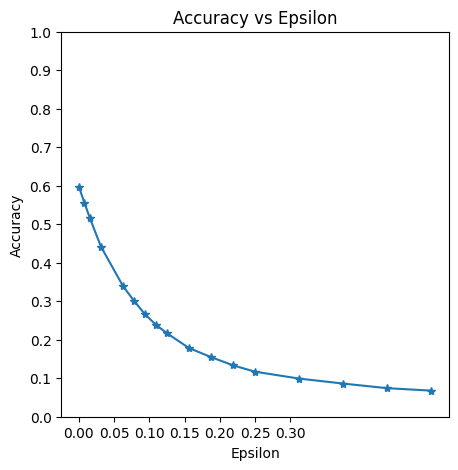

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_fgsm, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

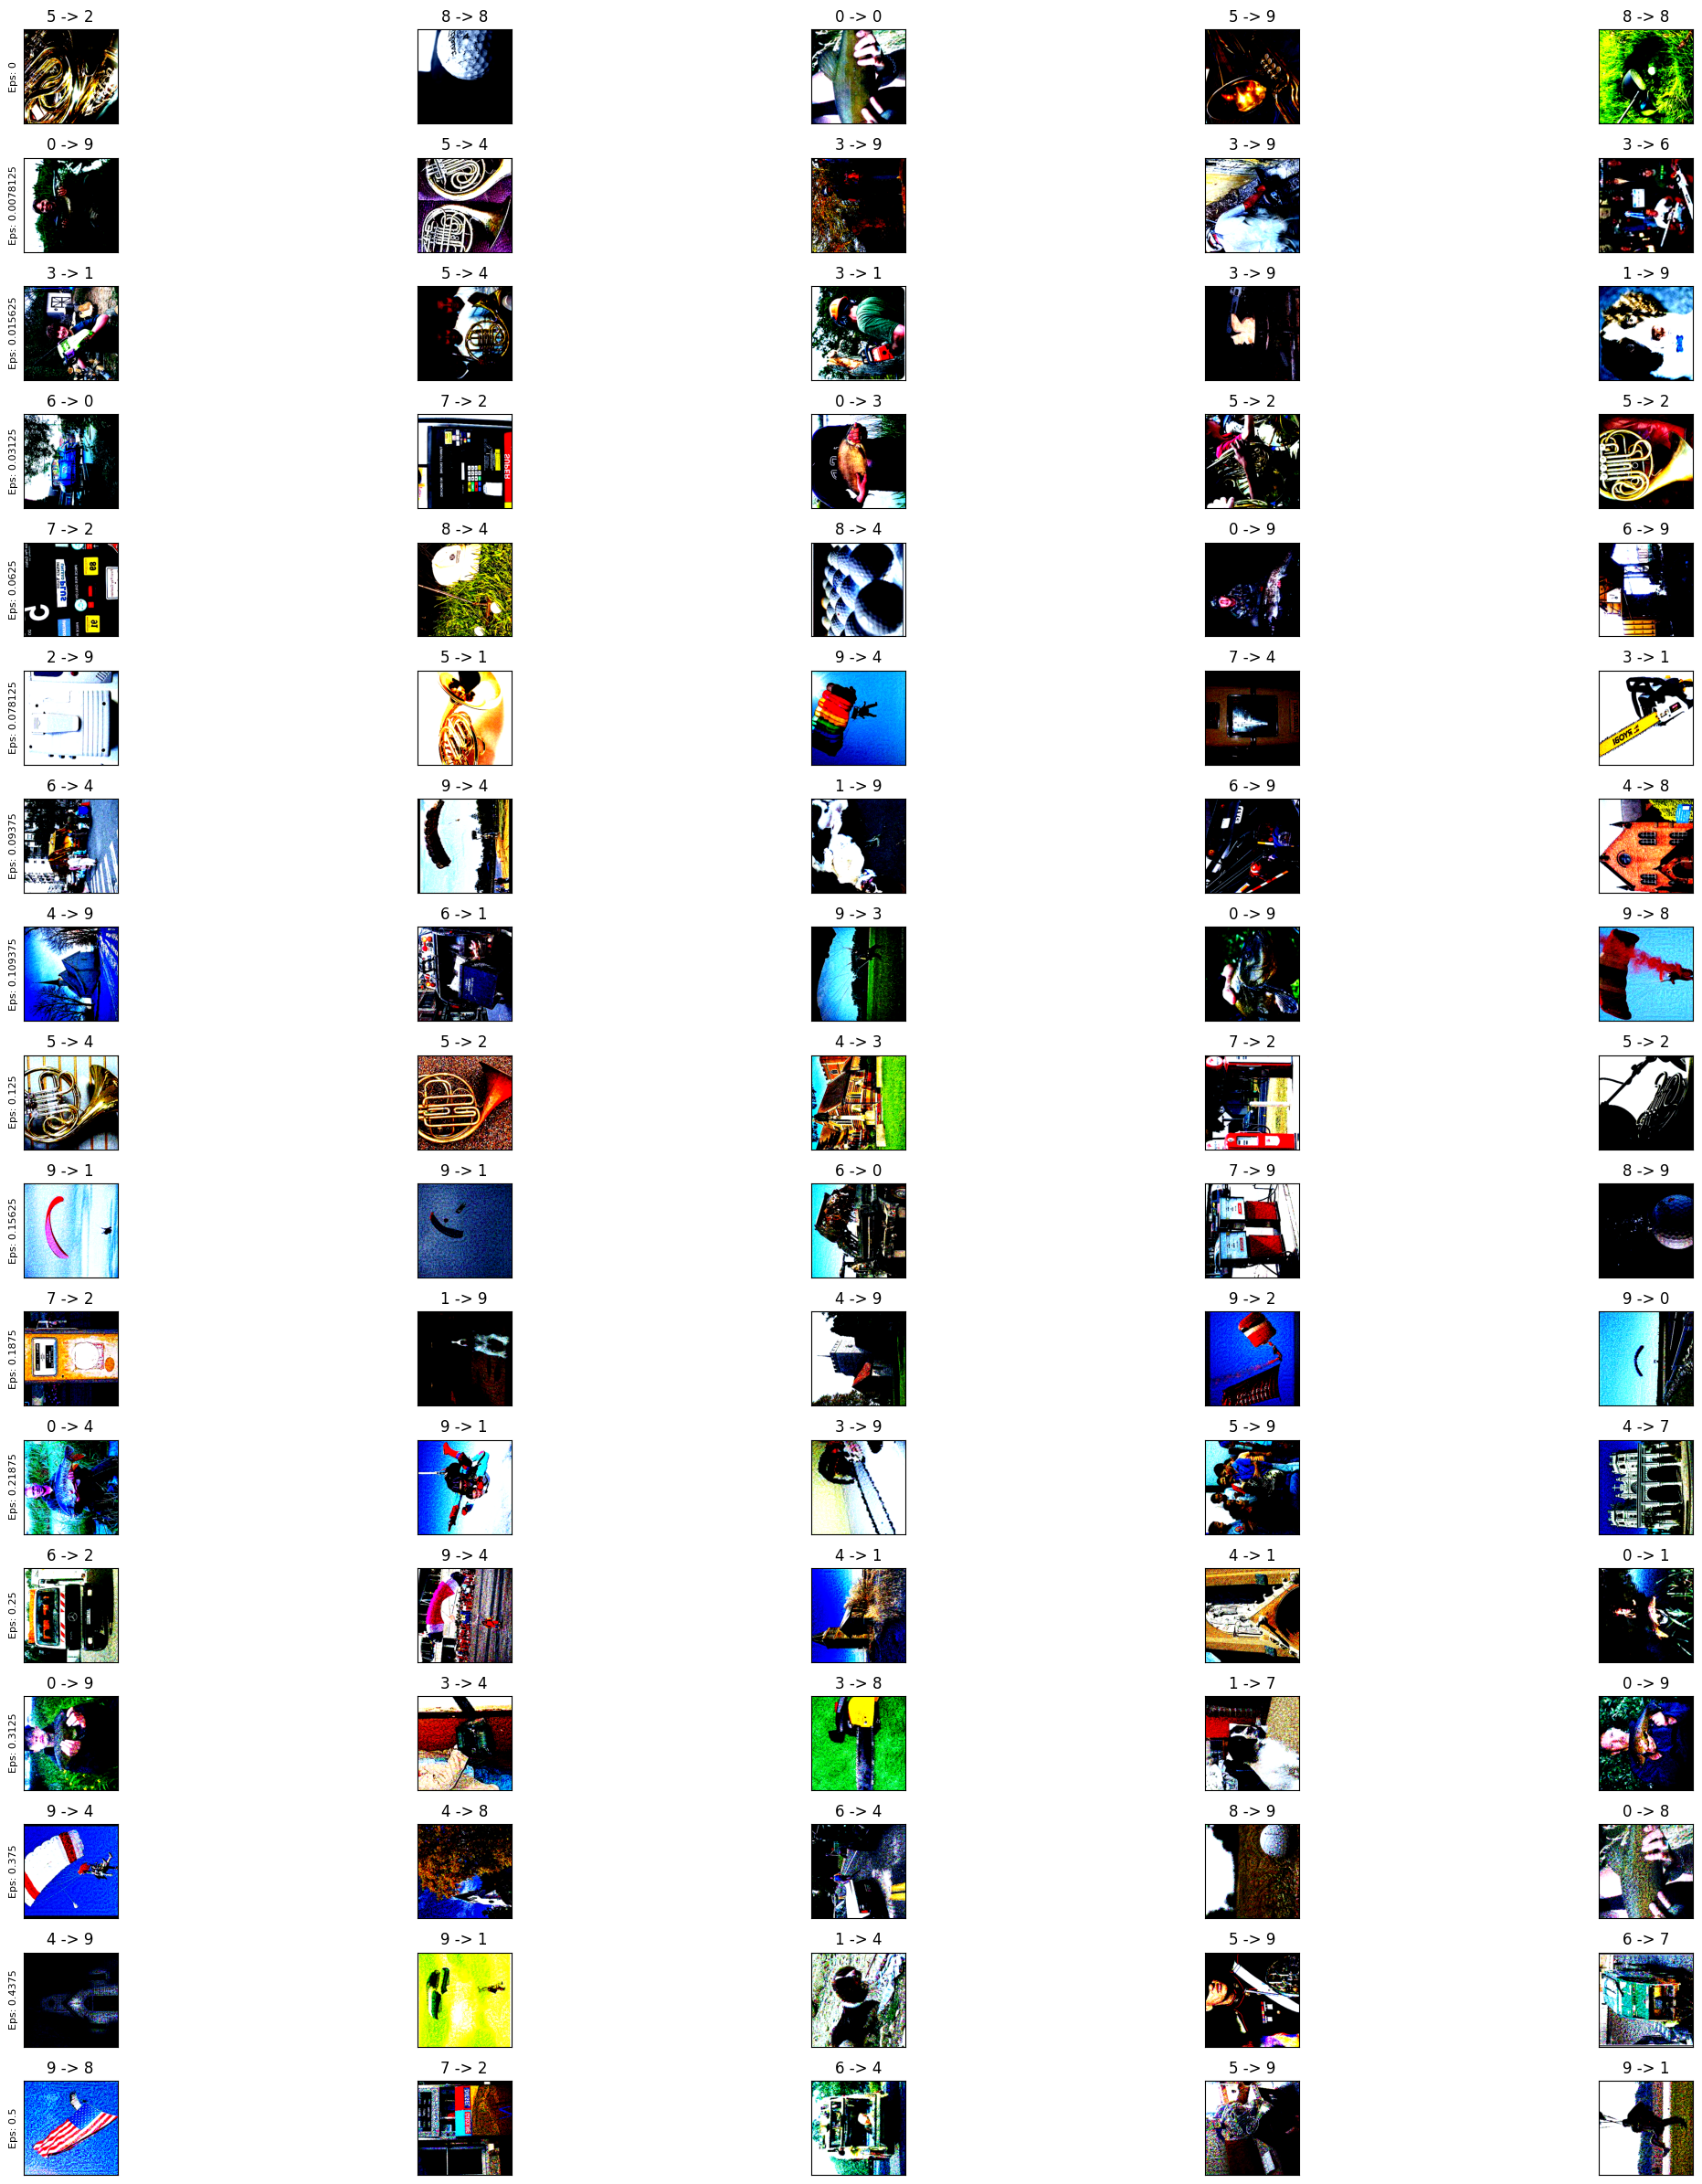

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(32,32))
for i in range(len(epsilons)):
    for j in range(len(examples_fgsm[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_fgsm[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_fgsm[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.T)
plt.tight_layout()
plt.show()

# Iterative gradient sign method/Basic iterative method

In [ ]:
# These are normalized epsilon values, when scaled to 256, these are originally = [0, 2.0, 4.0, 8.0, 16.0, 20.0, 24.0, 28.0, 32.0, 40.0, 48.0, 56.0, 64.0, 80.0, 96.0, 112.0, 128.0]
epsilons  = [0, 0.0078125, 0.015625, 0.03125, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.3125, 0.375, 0.4375, 0.5]
alpha     = 0.25
num_iter  = 10

In [ ]:
def iterative_attack(model, image, label, epsilon, alpha, num_item):
    # Set the model to evaluation mode
    model.eval()

    # Create a copy of the input image to perturb
    perturbed_image = image.clone()

    for i in range(num_iter):
        # Set requires_grad attribute of tensor. Important for attack
        perturbed_image = image.clone().detach()
        perturbed_image.requires_grad = True

        # Forward pass the data through the model
        output = model(perturbed_image)

        # Calculate the loss
        loss = F.cross_entropy(output, label)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect the element-wise sign of the data gradient
        data_grad       = perturbed_image.grad.data
        sign_data_grad  = data_grad.detach().sign()

        # Create the perturbed image by adjusting each pixel of the input image
        perturbed_image = perturbed_image + alpha*sign_data_grad

        # Project the perturbation onto an epsilon ball
        perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon).clamp(0, 1)

    # Return the perturbed image
    return perturbed_image


In [ ]:
def test_bim(model, device, test_loader, epsilon, alpha, num_item):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i, data_pair in enumerate(tqdm(test_loader)):
        sleep(0.01)

        data, target  = data_pair

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        init_pred = init_pred.squeeze()

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Call Iterative attack Attack
        perturbed_data = iterative_attack(model, data, target, epsilon, alpha, num_item)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Run the attack

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

0

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

KeyError: ignored

In [ ]:
accuracies_bim = []
examples_bim = []

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# Run test for each epsilon
for eps in epsilons:
    print('Value of epsilon = ', eps)
    acc, ex = test_bim(model, device, test_loader, eps, alpha, num_iter)
    accuracies_bim.append(acc)
    examples_bim.append(ex)

Value of epsilon =  0


  0%|          | 0/3925 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## Accuracy - epsilon

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_bim, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

#  Least Likely Class Methods

In [ ]:
# These are normalized epsilon values, when scaled to 256, these are originally = [0, 2.0, 4.0, 8.0, 16.0, 20.0, 24.0, 28.0, 32.0, 40.0, 48.0, 56.0, 64.0, 80.0, 96.0, 112.0, 128.0]
epsilons = [0, 0.0078125, 0.015625, 0.03125, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.3125, 0.375, 0.4375, 0.5]
alpha     = 0.25
num_iter  = 10

In [ ]:
def iterative_least_likely_attack(model, image, label, epsilon, alpha, num_item):
    # Set the model to evaluation mode
    model.eval()

    # Create a copy of the input image to perturb
    perturbed_image = image.clone()

    for i in range(num_iter):
        # Set requires_grad attribute of tensor. Important for attack
        perturbed_image = image.clone().detach()
        perturbed_image.requires_grad = True

        # Forward pass the data through the model
        output = model(perturbed_image)
        least_likeliest_class = torch.argmin(output)
        least_likeliest_class.unsqueeze_(0)

        # Calculate the loss
        loss = F.cross_entropy(output, least_likeliest_class)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect the element-wise sign of the data gradient
        data_grad       = perturbed_image.grad.data
        sign_data_grad  = data_grad.detach().sign()

        # Create the perturbed image by adjusting each pixel of the input image
        prime_image = perturbed_image - alpha * sign_data_grad

        # Project the perturbation onto an epsilon ball
        prime_image = torch.max(torch.min(prime_image, image + epsilon), image - epsilon).clamp(0, 1)

    # Return the perturbed image
    return prime_image


In [ ]:
def test_iilm(model, device, test_loader, epsilon, alpha, num_item):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i, data_pair in enumerate(tqdm(test_loader)):
        sleep(0.01)

        data, target  = data_pair

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        init_pred = init_pred.squeeze()

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Call Iterative attack Attack
        perturbed_data = iterative_least_likely_attack(model, data, target, epsilon, alpha, num_item)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

### Run the attack

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
accuracies_iilm = []
examples_iilm = []

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

# Run test for each epsilon
for eps in epsilons:
    print('Value of epsilon = ', eps)
    acc, ex = test_iilm(model, device, test_loader, eps, alpha, num_iter)
    accuracies_iilm.append(acc)
    examples_iilm.append(ex)

## Accuracy - epsilon

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_iilm, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()